In [ ]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,12600.0,3569.400000,12.157324,1,2.0,0.057153,0.527227,0.513171,0.117428,2545.0,0
1,9000.0,2722.188351,7.000000,0,2.0,0.657661,0.285898,0.614414,0.222700,495.0,0
2,15750.0,4477.500000,12.000000,0,2.0,0.501213,0.695423,0.513171,0.117428,1212.0,0
3,9000.0,1309.050000,12.157324,0,3.0,0.501213,0.155973,0.513171,0.117428,515.0,0
4,7650.0,1125.000000,12.157324,0,2.0,0.294328,0.152076,0.513171,0.117428,162.0,0


In [3]:
# separacao das variaveis explicativas e alvo

x = data.drop("inadimplente", axis=1)
y = data["inadimplente"]

In [4]:
# como aparentemente nao ha variaveis categoricas e a alvo ja esta em formato numerico, nao vai precisar de nenhuma transofrmacao nesse sentido
# divisao dos dados vai ser % para treino e 15% para teste

from sklearn.model_selection import train_test_split

x, x_teste, y, y_teste = train_test_split(
    x, y, random_state=5, test_size=0.15, stratify=y
)
x_treino, x_validacao, y_treino, y_validacao = train_test_split(
    x, y, random_state=5, stratify=y
)

In [5]:
from sklearn.tree import DecisionTreeClassifier

arvore = DecisionTreeClassifier(random_state=12, max_depth=10)
arvore.fit(x_treino, y_treino)
print(arvore.score(x_teste, y_teste))
print(arvore.score(x_validacao, y_validacao))

0.9067127344521224
0.9057573382109573


## matriz de confusao

[[10356   123]
 [  959    43]]


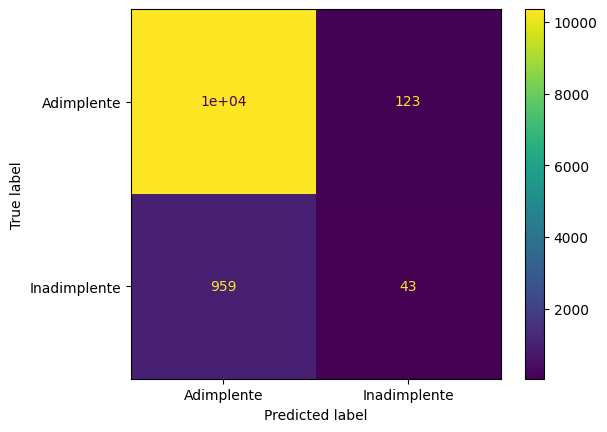

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_prev = arvore.predict(x_validacao)
matriz_confusao = confusion_matrix(y_validacao, y_prev)
print(matriz_confusao)

visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=["Adimplente", "Inadimplente"])
visualizacao.plot()

## random forest

0.9125123395853899
[[10477     2]
 [  998     4]]


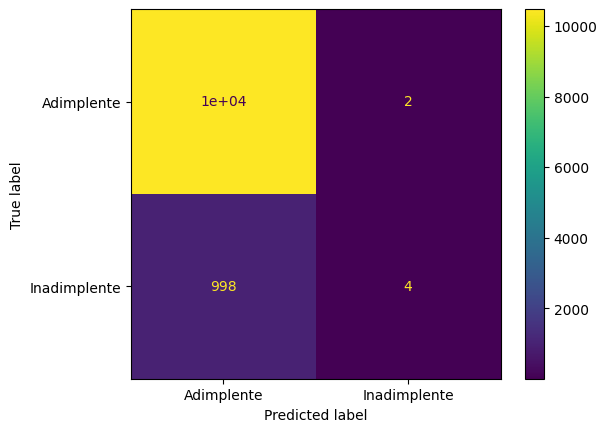

In [7]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(random_state=12, max_depth=10)
modelo.fit(x_treino, y_treino)
print(modelo.score(x_teste, y_teste))

y_prev_forest = modelo.predict(x_validacao)
matriz_confusao_forest = confusion_matrix(y_validacao, y_prev_forest)
print(matriz_confusao_forest)

visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_forest, display_labels=["Adimplente", "Inadimplente"])
visualizacao.plot()

In [8]:
from sklearn.metrics import accuracy_score

# matriz é 
# [[TP  FP]
# [FN  TN]]
print("acuracia: ", accuracy_score(y_validacao, y_prev_forest))
# a acuracia nao é uma metrica adequada porque a base de dados é desbalanceada = tp + tn / tp + tn + fp + fn

# a precisao = verdadeiros positivos / (verdadeiros positivos + falsos positivos)
from sklearn.metrics import precision_score
print("precisao: ", precision_score(y_validacao, y_prev_forest))

# o recall leva em consideracao os falsos negativos = verdadeiros positivos / (verdadeiros positivos + falsos negativos)
from sklearn.metrics import recall_score
print("recall: ", recall_score(y_validacao, y_prev_forest))


acuracia:  0.9128995732079087
precisao:  0.6666666666666666
recall:  0.003992015968063872


a metrica mais relevante depende do contexto do problema, no caso de inadimplencia, o recall é mais relevante, pois queremos identificar os inadimplentes, para evitar prejuizos, os falsos positivos apenas farao perder clientes bons, mas os falsos negativos podem gerar prejuizos financeiros maiores


In [9]:
from sklearn.metrics import f1_score
# f1 score é a media harmonica entre precisao e recall, = 2 x precisao x recall / (precisao + recall)

print("f1 score: ", f1_score(y_validacao, y_prev_forest))

f1 score:  0.007936507936507936


## curva roc

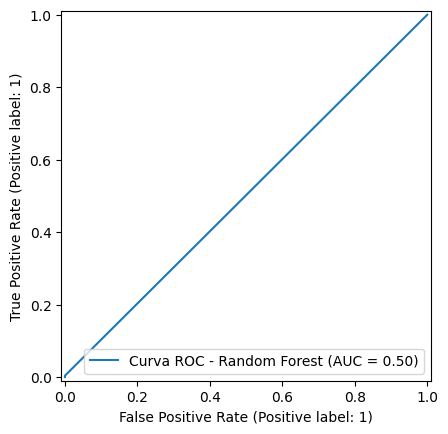

In [10]:
# a curva roc serve para avaliar se o nosso modelo ta conseguindo diferenciar bem uma classe da outra

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_validacao, y_prev_forest, name="Curva ROC - Random Forest")


In [11]:
from sklearn.metrics import roc_auc_score

print("AUC ROC: ", roc_auc_score(y_validacao, y_prev_forest))

AUC ROC:  0.5019005790308876


AUC PR:  0.09464563086733557


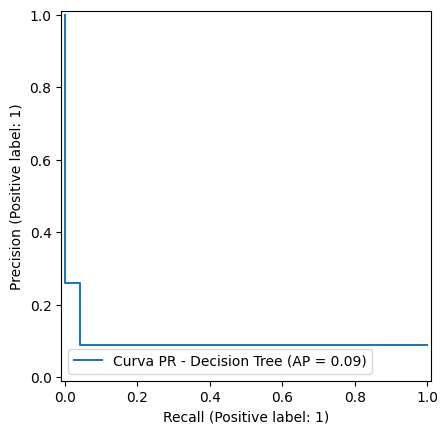

In [12]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

PrecisionRecallDisplay.from_predictions(y_validacao, y_prev, name="Curva PR - Decision Tree")
print("AUC PR: ", average_precision_score(y_validacao, y_prev))

## relatorio de metricas

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_validacao, y_prev_forest, target_names=["Adimplente", "Inadimplente"]))

              precision    recall  f1-score   support

  Adimplente       0.91      1.00      0.95     10479
Inadimplente       0.67      0.00      0.01      1002

    accuracy                           0.91     11481
   macro avg       0.79      0.50      0.48     11481
weighted avg       0.89      0.91      0.87     11481



## validacao cruzada - KFold

In [42]:
from sklearn.model_selection import KFold, cross_validate

In [70]:
def intevalo_confianca(resultados, metrica="test_score"):
    media = resultados[metrica].mean()
    desvio_padrao = resultados[metrica].std()
    print(f"Intervalo de confiança({metrica}): [{media-2*desvio_padrao}, {min(media+2*desvio_padrao, 1.0)}]")

In [55]:
def relatorio_metricas(resultados):
    for metrica in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
        intevalo_confianca(resultados, metrica=metrica)


In [56]:
modelo = DecisionTreeClassifier(max_depth = 10)
kf = KFold(n_splits=5, shuffle = True, random_state = 5)
cv_resultados = cross_validate(modelo, x, y, cv=kf, scoring = ['accuracy','recall', 'precision', 'f1'])
cv_resultados


{'fit_time': array([0.13863492, 0.11759996, 0.11697531, 0.12012386, 0.12070203]),
 'score_time': array([0.00997615, 0.00629592, 0.00621104, 0.00642395, 0.00676417]),
 'test_accuracy': array([0.91290147, 0.90744774, 0.90744774, 0.91387195, 0.89949913]),
 'test_recall': array([0.03038309, 0.01980198, 0.02091021, 0.0156658 , 0.02427746]),
 'test_precision': array([0.25842697, 0.21621622, 0.23943662, 0.24489796, 0.21      ]),
 'test_f1': array([0.05437352, 0.03628118, 0.03846154, 0.02944785, 0.04352332])}

In [57]:
relatorio_metricas(cv_resultados)

Intervalo de confiança(test_accuracy): [0.8979922695836635, 0.9184749385404749]
Intervalo de confiança(test_recall): [0.012353230066788373, 0.03206218330978387]
Intervalo de confiança(test_precision): [0.19760657051259287, 0.2699845340515409]
Intervalo de confiança(test_f1): [0.023787755316936634, 0.057047208235624036]


## estratificacao dos dados

In [58]:
data["inadimplente"].value_counts(normalize=True)

inadimplente
0    0.912707
1    0.087293
Name: proportion, dtype: float64

In [59]:
from sklearn.model_selection import StratifiedKFold #mantem a proporcao entre os dados

modelo = DecisionTreeClassifier(max_depth=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo, x, y, cv= skf, scoring="recall")
cv_resultados


{'fit_time': array([0.13137722, 0.11703515, 0.11711383, 0.11616516, 0.1243372 ]),
 'score_time': array([0.0036757 , 0.00331378, 0.00310516, 0.00344086, 0.00331283]),
 'test_score': array([0.03491272, 0.02871411, 0.0286783 , 0.02369077, 0.02743142])}

## Oversampling - Smote

In [60]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_balanceado, y_balanceado = oversample.fit_resample(x, y)

y_balanceado.value_counts(normalize=True)


inadimplente
0    0.5
1    0.5
Name: proportion, dtype: float64

In [61]:
modelo = DecisionTreeClassifier(max_depth=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo, x_balanceado, y_balanceado, cv=skf, scoring="recall")

In [62]:
cv_resultados

{'fit_time': array([0.26248431, 0.25016999, 0.24994397, 0.24946785, 0.24832106]),
 'score_time': array([0.0042069 , 0.00423717, 0.00456595, 0.00466084, 0.00429273]),
 'test_score': array([0.74123121, 0.76461465, 0.72694739, 0.75426458, 0.71331424])}

Alguns dos algoritmos de oversampling da biblioteca:

RandomOversampler
SMOTE
ADASYN
KMeansSMOTE
Alguns dos algoritmos de undersampling da biblioteca:

RandomUnderSampler
NearMiss
ClusterCentroids
TomekLinks
Algoritmos que combinam as duas técnicas de oversampling e undersampling:

SMOTEENN
SMOTETomek

o nosso resultado melhorou, porem é importante lembrar que os dados na vida real nao estarao balanceados, entao é importante fazer o teste com os dados desbalanceados

In [63]:
from imblearn.pipeline import Pipeline as imbpipeline

modelo = DecisionTreeClassifier()
pipeline = imbpipeline([
    ("oversample", SMOTE()),
    ("arvore", modelo)
])

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(pipeline, x, y, cv=skf, scoring="recall")

intevalo_confianca(cv_resultados)

Intervalo de confiança(test_score): [0.28024070227360753, 0.2969617348296394]


## Undersampling - NearMiss

In [ ]:
from imblearn.under_sampling import NearMiss

modelo = DecisionTreeClassifier(max_depth=10)
pipeline = imbpipeline([("oversample", SMOTE()), ("arvore", modelo)])